## Synopsis
This code generates the final figure for the SAXS results. 

The fits of SAXS at each temperature is performed using the Lorentian function: 

$$ \large I(q,T) = \frac{I_{q_0}(T)}{1+[\xi(T) \cdot q]^\eta} $$  

Here, $\xi(T)$ is the characteristic length at temperature $T$, and $I_{q_0}$ corresponds to the SAXS intensity at $q=0$.
$\eta$ is extracted by fitting the global scaled curve with the Lorentzian form from `SAXS_Scale_Fit`.

However, since the Lorentzian does not very well describe the data, the final $\xi(T)$ (as plotted in Fig. b) is extracted from the global scaling **without fitting to any function**. $\xi(T)$ is then fitted over $a \cdot (T-T_0)^b$ to determine the critical temperature $T_0$ and the error on the power argument $b$.


### Initialize

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import csv
from scipy.optimize import minimize
from matplotlib.lines import Line2D

from saxs_tools import preprocess_data
from saxs_tools import lorentzian_fit
from saxs_tools import lorentzian_fit_fix_b
from saxs_tools import optimize_T0_log


### Load SAXS data

In [2]:

with open('8IDI_reduced_H06.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

avg_ramp_up_cleaned, ql_sta_cleaned = preprocess_data(avg_ramp_up, ql_sta)
ql = ql_sta_cleaned[0]
t_list = [np.nanmean(avg_dict['temperature']) for avg_dict in avg_ramp_up]

I_list = np.zeros((len(ql), len(ql_sta_cleaned)))
for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I_list[:,i] = data


### Clipping temperature list

In [3]:

# Excluding the highest temperature from the fit and the plot.
# The highest temperature significantly deviate from the fit so the fit would fall,
# plus, and adding the SAXS at the highest temperature does not provide any new info as
# the high-Q scaling looks similar.

# To show the highest temperature, remove -1. The code should still work, except
# the highest temperature should be excluded from the fit or the code crashes.
temperatures = np.array(t_list[:-1])
num_T = len(ql_sta_cleaned)-1


### Fit SAXS at every temperature with the Lorentzian fit of fixed η

In [4]:

# Fit each curve and also extract uncertainties from the covariance matrix.
Iq0 = np.zeros((num_T))
Iq0_err = np.zeros((num_T))
xi = np.zeros((num_T))
xi_err = np.zeros((num_T))

for i in range(num_T):
    popt, pcov = curve_fit(lorentzian_fit_fix_b, q, I_list[:,i], 
                           p0=[np.max(I_list[:,i]), 1],
                           bounds=([0, 0], [np.inf, np.inf]))
    perr = np.sqrt(np.diag(pcov))
    Iq0[i] = popt[0]
    Iq0_err[i] = perr[0]
    xi[i] = popt[1]
    xi_err[i] = perr[1]
    

### (Fig. a) Plot SAXS at every temperature with the Lorentzian fit of fixed η

<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:42: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3044913/4117577083.py:42: SyntaxWarning: invalid escape sequence '\c'
  color=colors[i], label=f'{temperatures[i]:.1f}($^\circ$C)',


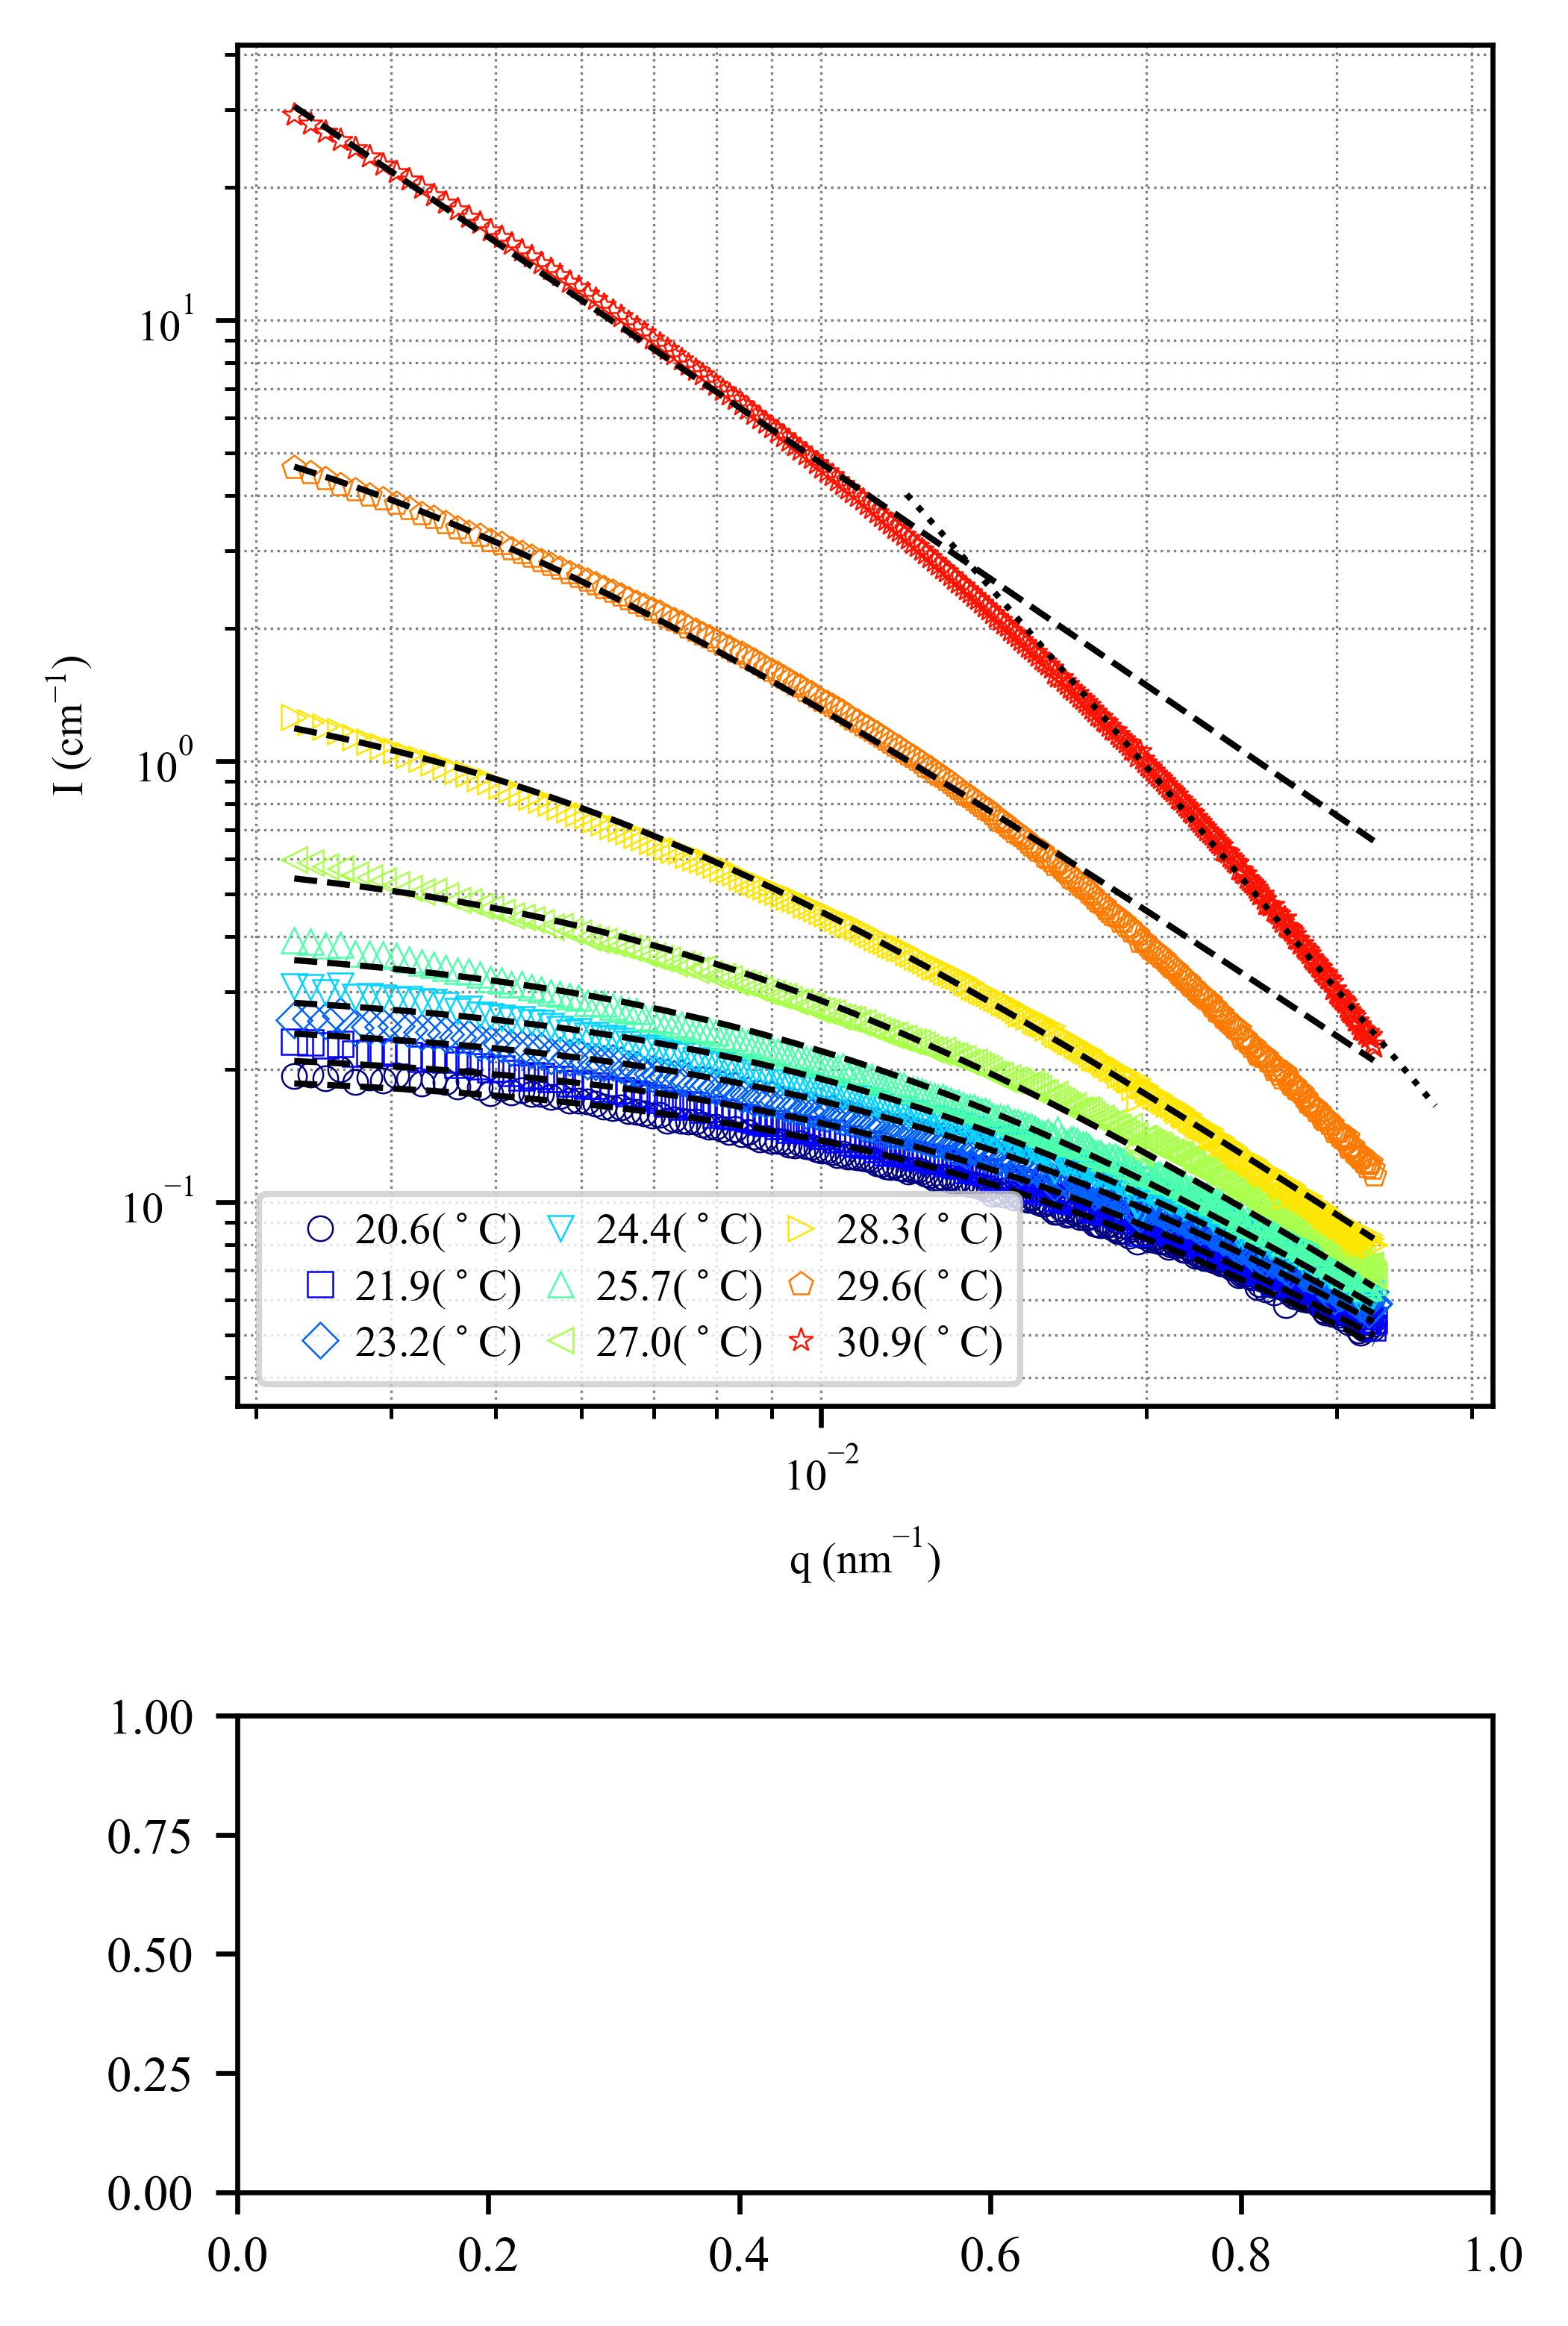

In [5]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 600

figure_width_mm = 86
figure_width_inches = figure_width_mm / 25.4

# --------------------------
# Plotting setup for main figure with 3 subplots
fig = plt.figure(figsize=(figure_width_inches, figure_width_inches * 1.5), constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[2, 0.7], hspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])  # Subplot (a)
ax2 = fig.add_subplot(gs[1, 0])  # Subplot (b)
# ax3 = fig.add_subplot(gs[1, 1])  # Subplot (c)
# Colormap and marker style
cmap = plt.get_cmap('jet')
colors = [cmap(i / num_T) for i in range(num_T)]
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*']

# Plot I vs. Q at different temperature
for ii in range(num_T):
    ax1.loglog(ql, I_list[:,ii], marker_styles[ii % len(marker_styles)], 
               color=colors[ii], markersize=4, markerfacecolor='none', markeredgewidth=0.3)
for jj in range(num_T):
    Iq_fit = lorentzian_fit_fix_b(q, Iq0[jj], xi[jj])
    ax1.loglog(q, Iq_fit, '--', color='black', linewidth=1)

# Add manual curve that shows q scaling at higher q and higher temperature
qx_test = np.logspace(np.log10(1.2e-2), np.log10(3.7e-2), 100)
I_test = lorentzian_fit(qx_test, 5.5e1, 2e2, 2.9)
ax1.loglog(qx_test, I_test, ':', color='black', linewidth=1)

ax1.set_xlabel('q ($\\mathdefault{nm^{-1}}$)', fontsize=7)
ax1.set_ylabel('I (cm$^\\mathdefault{-1}$)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.grid(which='both', linestyle=':', linewidth=0.4, color='gray')

# Add legend for temperature
legend_elements = [
    Line2D([0], [0], marker=marker_styles[i % len(marker_styles)], 
           color=colors[i], label=f'{temperatures[i]:.1f}($^\circ$C)',
           markersize=4, linewidth=0.4, linestyle='None', markerfacecolor='none', markeredgewidth=0.3)
    for i in range(num_T)
]
ax1.legend(handles=legend_elements, loc='lower left', fontsize=7, frameon=True, 
           ncol=3, labelspacing=0.3, handletextpad=-0.2, columnspacing=-0.1)
# plt.figure(fig)
# plt.show()



### (Fig. a inset) Plot global SAXS curve

$R_g$ is extracted from 12-ID-B SAXS results by Dr. Xiaobing Zuo

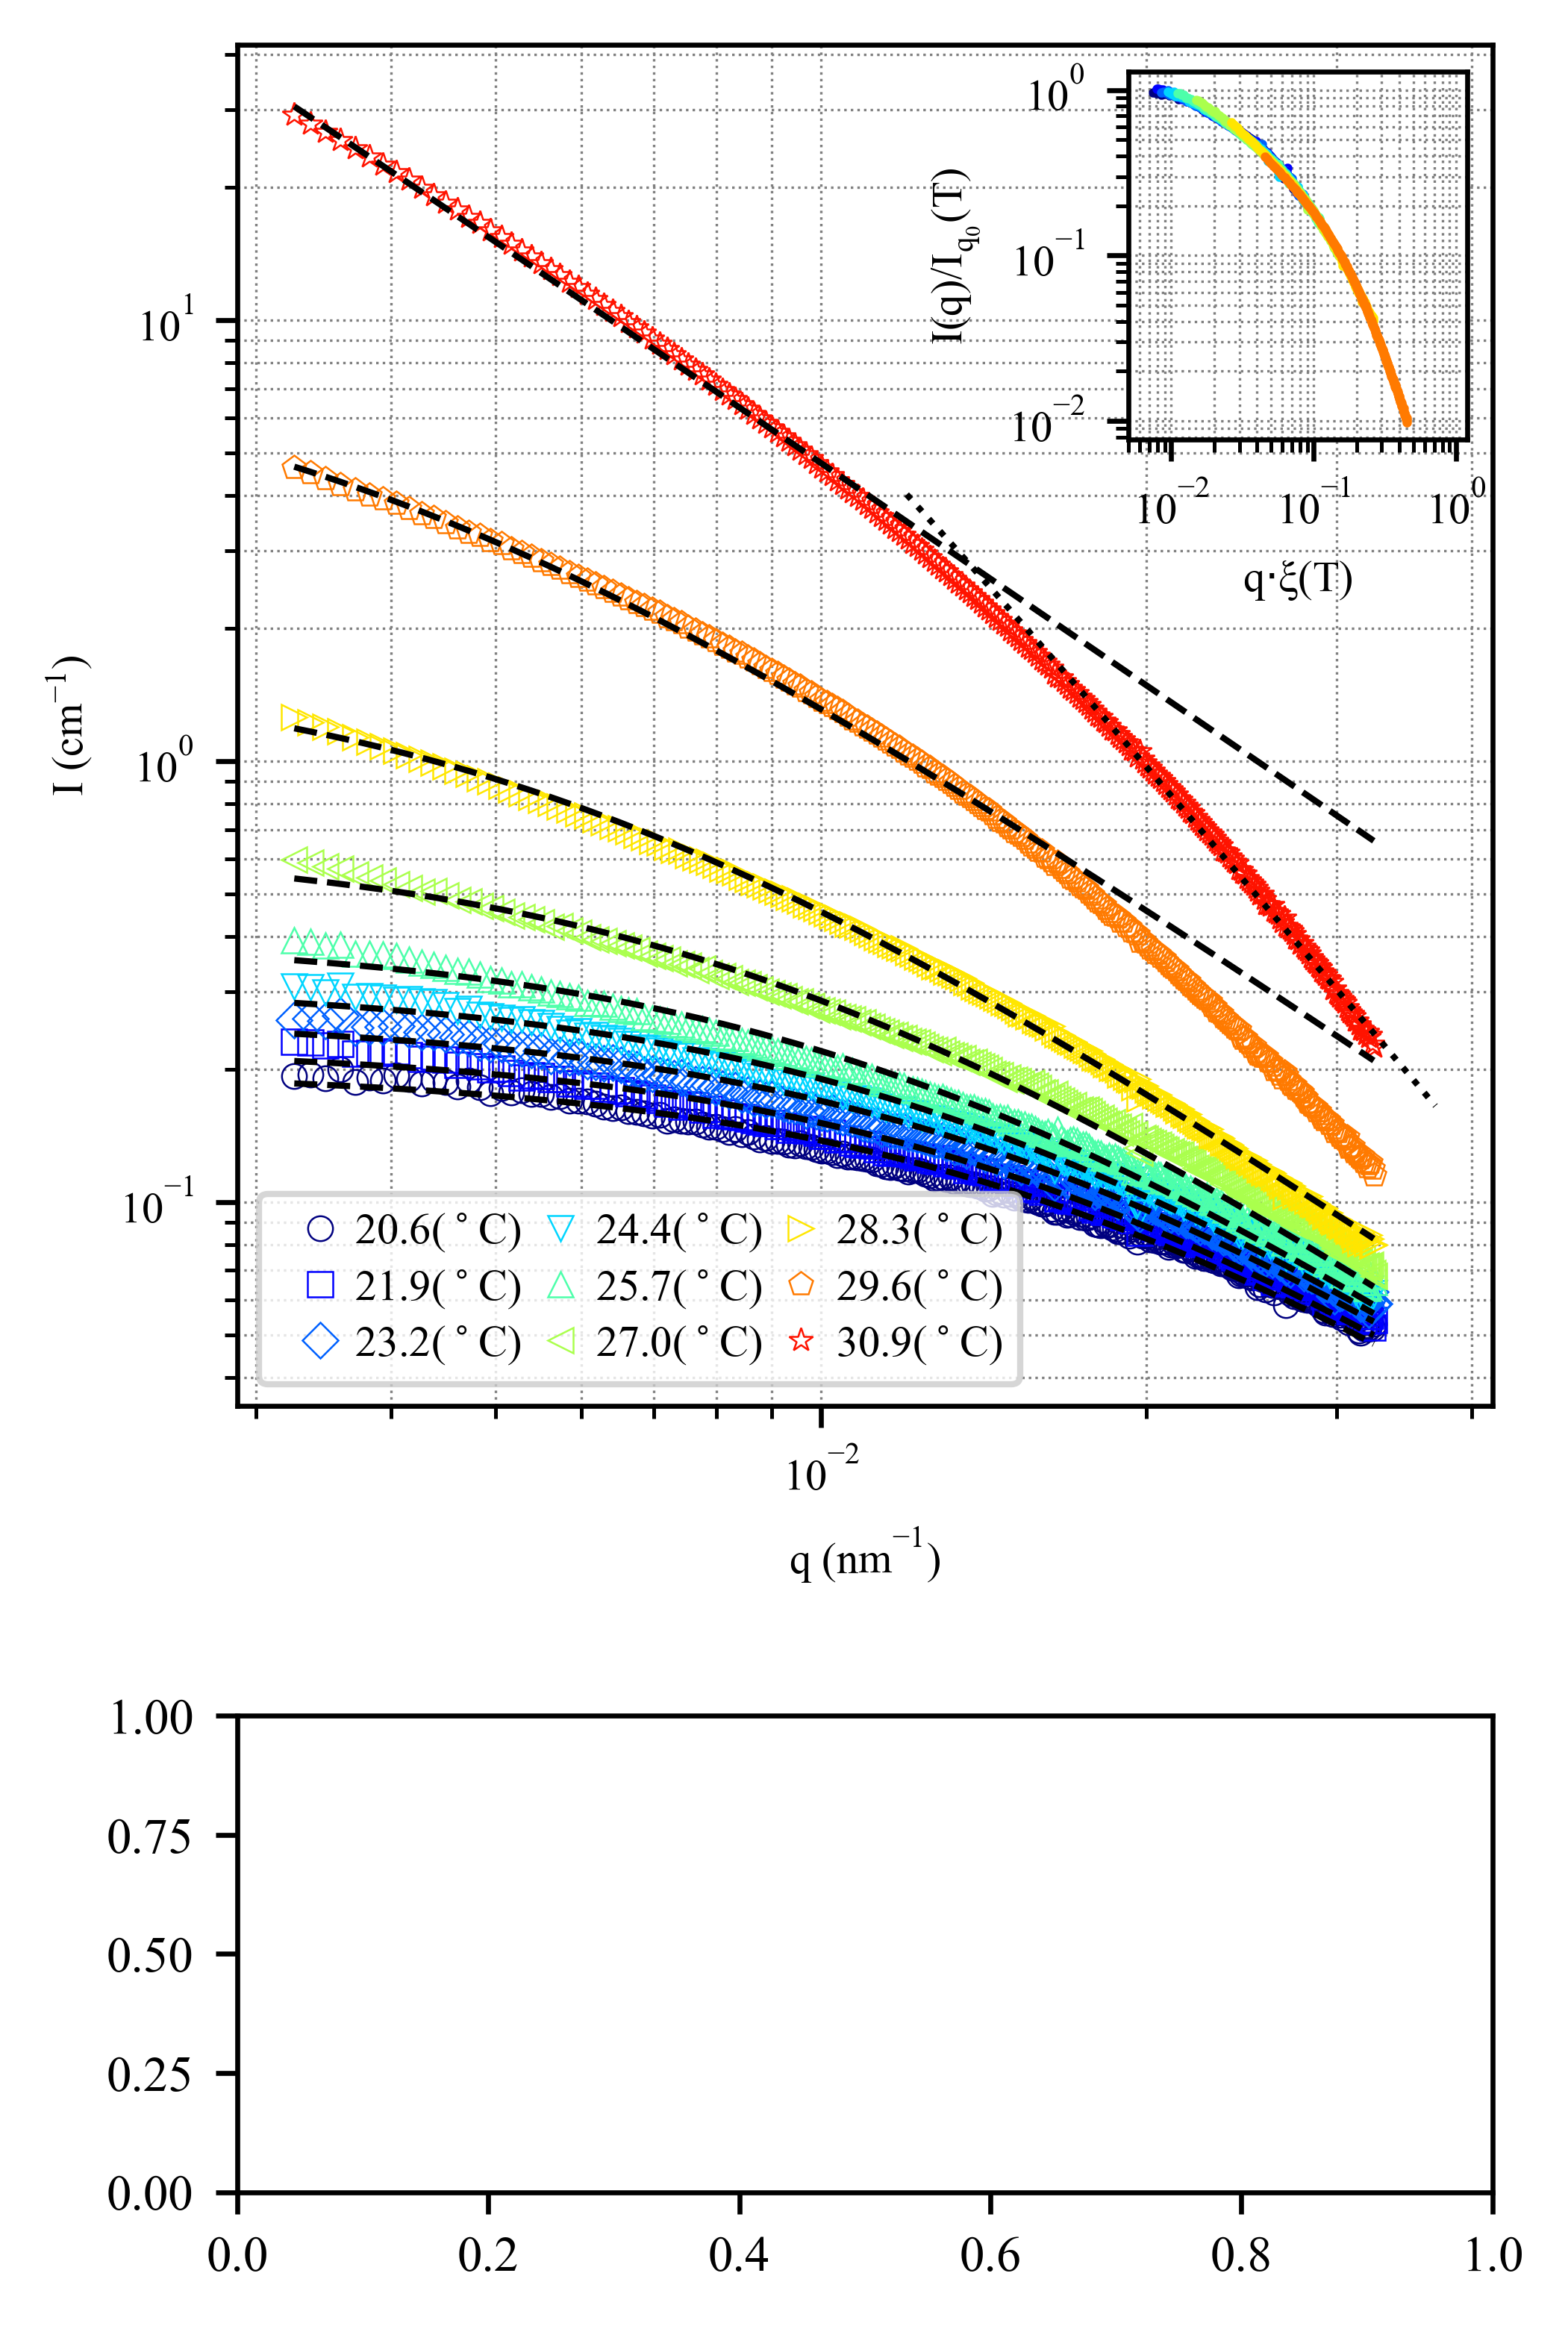

In [6]:

# Results from Dr. Zuo's Guinier fit at 12-ID-B
Rg = 2.28 
Rg_err = 0.04

with open('SAXS_Global_Scale.pickle', 'rb') as f:
    scaling_results = pickle.load(f)
    scaled_curves = pickle.load(f)

# Inset for Normalized and Fitted Curve in subplot (a)
# Exclude further the highest temperature (second highest from the original set)
# as it does overlap with the previous sets
ax_inset = ax1.inset_axes([0.71, 0.71, 0.27, 0.27])  # Position inset
for i in range(num_T-1):
    ax_inset.loglog(scaled_curves[i][0]*Rg, scaled_curves[i][1]/0.2, 'o', 
                    color=colors[i], markersize=0.5)
ax_inset.set_xlabel(r'q$\cdot\mathdefault{\xi(T)}$', fontsize=7)
ax_inset.set_ylabel(r'I(q)/I$\mathdefault{_{q_0}(T)}$', fontsize=7)
ax_inset.set_xlim(5e-3, 1.2)
ax_inset.tick_params(axis='both', which='major', labelsize=7)
ax_inset.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
plt.figure(fig)
plt.show()


### Extracting characteristic length from self-scaling (not the fit)

In [7]:

xi_scaling = scaling_results[:,1]
xi_scaling_err = scaling_results[:,4]
xi_scaling_err[0] = 1e-6
xi_scaling_err_propagated = (Rg_err/Rg+xi_scaling_err/xi_scaling)*xi_scaling

# The last two temps were excluded from the self-scaling because they do not overlap with the rest
temp_clip = temperatures[:-1]

best_T0, best_T0_err = optimize_T0_log(temp_clip, xi_scaling, xi_scaling_err, initial_delta=1.0, num_samples=1000)
T_diff = best_T0 - temp_clip



In [8]:
print(temp_clip)
print(best_T0)

[20.64583333 21.91691669 23.18366669 24.44358335 25.71575006 27.00783334
 28.3150833  29.61116662]
29.964432292573495


In [9]:

def exp_function(x, a, b):
    return a*x**b

popt, pcov = curve_fit(exp_function, T_diff, xi_scaling, sigma=xi_scaling_err)
standard_errors = np.sqrt(np.diag(pcov))

T_diff_fit = np.linspace(np.min(T_diff), np.max(T_diff), 100)
xi_fit_line = exp_function(T_diff_fit, *popt)

gamma = popt[1]
gamma_err = standard_errors[1]


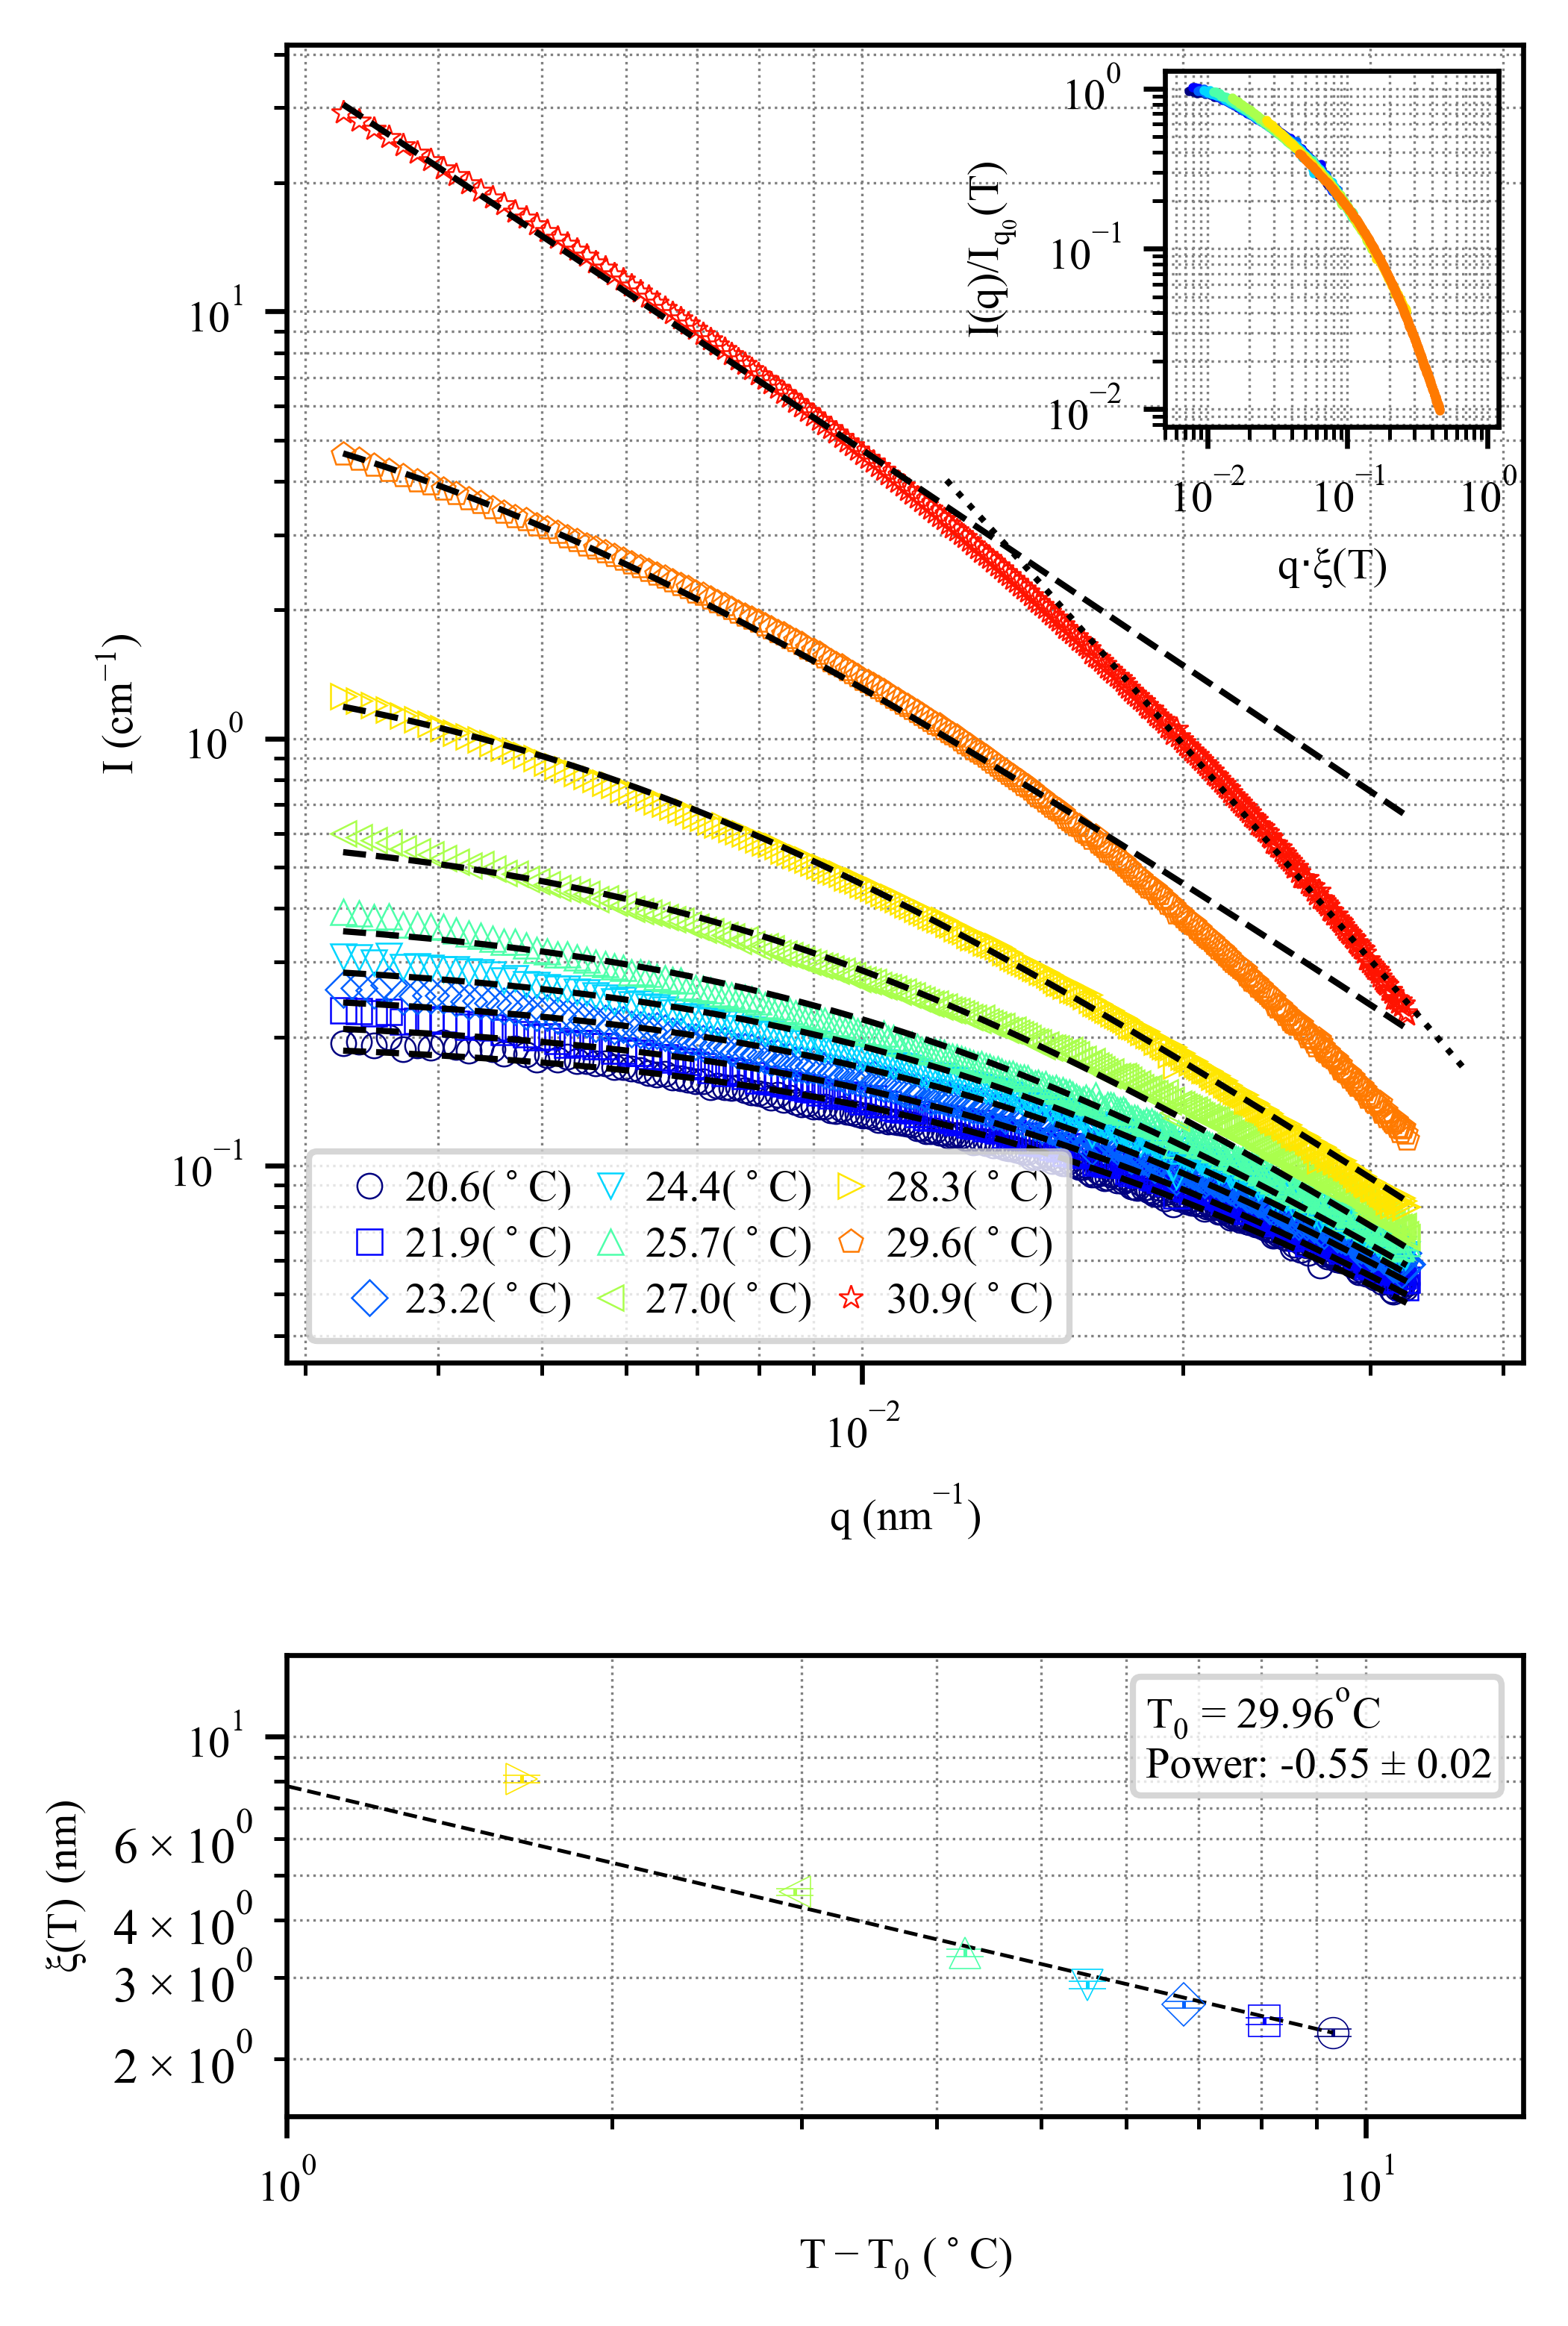

In [10]:

for i in range(len(T_diff)):
    ax2.errorbar(T_diff[i], Rg*xi_scaling[i], yerr=Rg*xi_scaling_err_propagated[i], 
                 fmt=marker_styles[i % len(marker_styles)], 
                 color=colors[i], markersize=5, markerfacecolor='none', markeredgewidth=0.2, 
                 linewidth=0, elinewidth=0.6, capsize=3)  # Reduced elinewidth, added capsize
ax2.plot(T_diff_fit, Rg*xi_fit_line, '--', color='black', linewidth=0.6, label="_nolegend_")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$\mathdefault{T-T_0}$ ($^\circ$C)', fontsize=7)
ax2.set_ylabel(r'$\mathdefault{\xi(T)\ (nm)}$', fontsize=7)
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.set_xlim(1, 14)
ax2.set_ylim(1.5, 1.5e1)
# ax3.yaxis.set_label_coords(-0.15, 0.5)
ax2.grid(which='both', linestyle=':', linewidth=0.4, color='gray')
text1 = r'$\mathdefault{T_0}$'
text2 = r'$\mathdefault{^{o}C}$'

# Plot the legend box. Remove the marker and the extra white space on the left.
dummy_plot, = ax2.plot([], [], linestyle='', 
                       label=f'{text1} = {best_T0:.2f}{text2} \nPower: {gamma:.2f} ± {gamma_err:.2f}')
ax2.legend(handles=[dummy_plot], fontsize=7,  
           handlelength=0, 
           handletextpad=0.1, 
           borderpad=0.2, labelspacing=0.2, frameon=True)

plt.figure(fig)
plt.show()



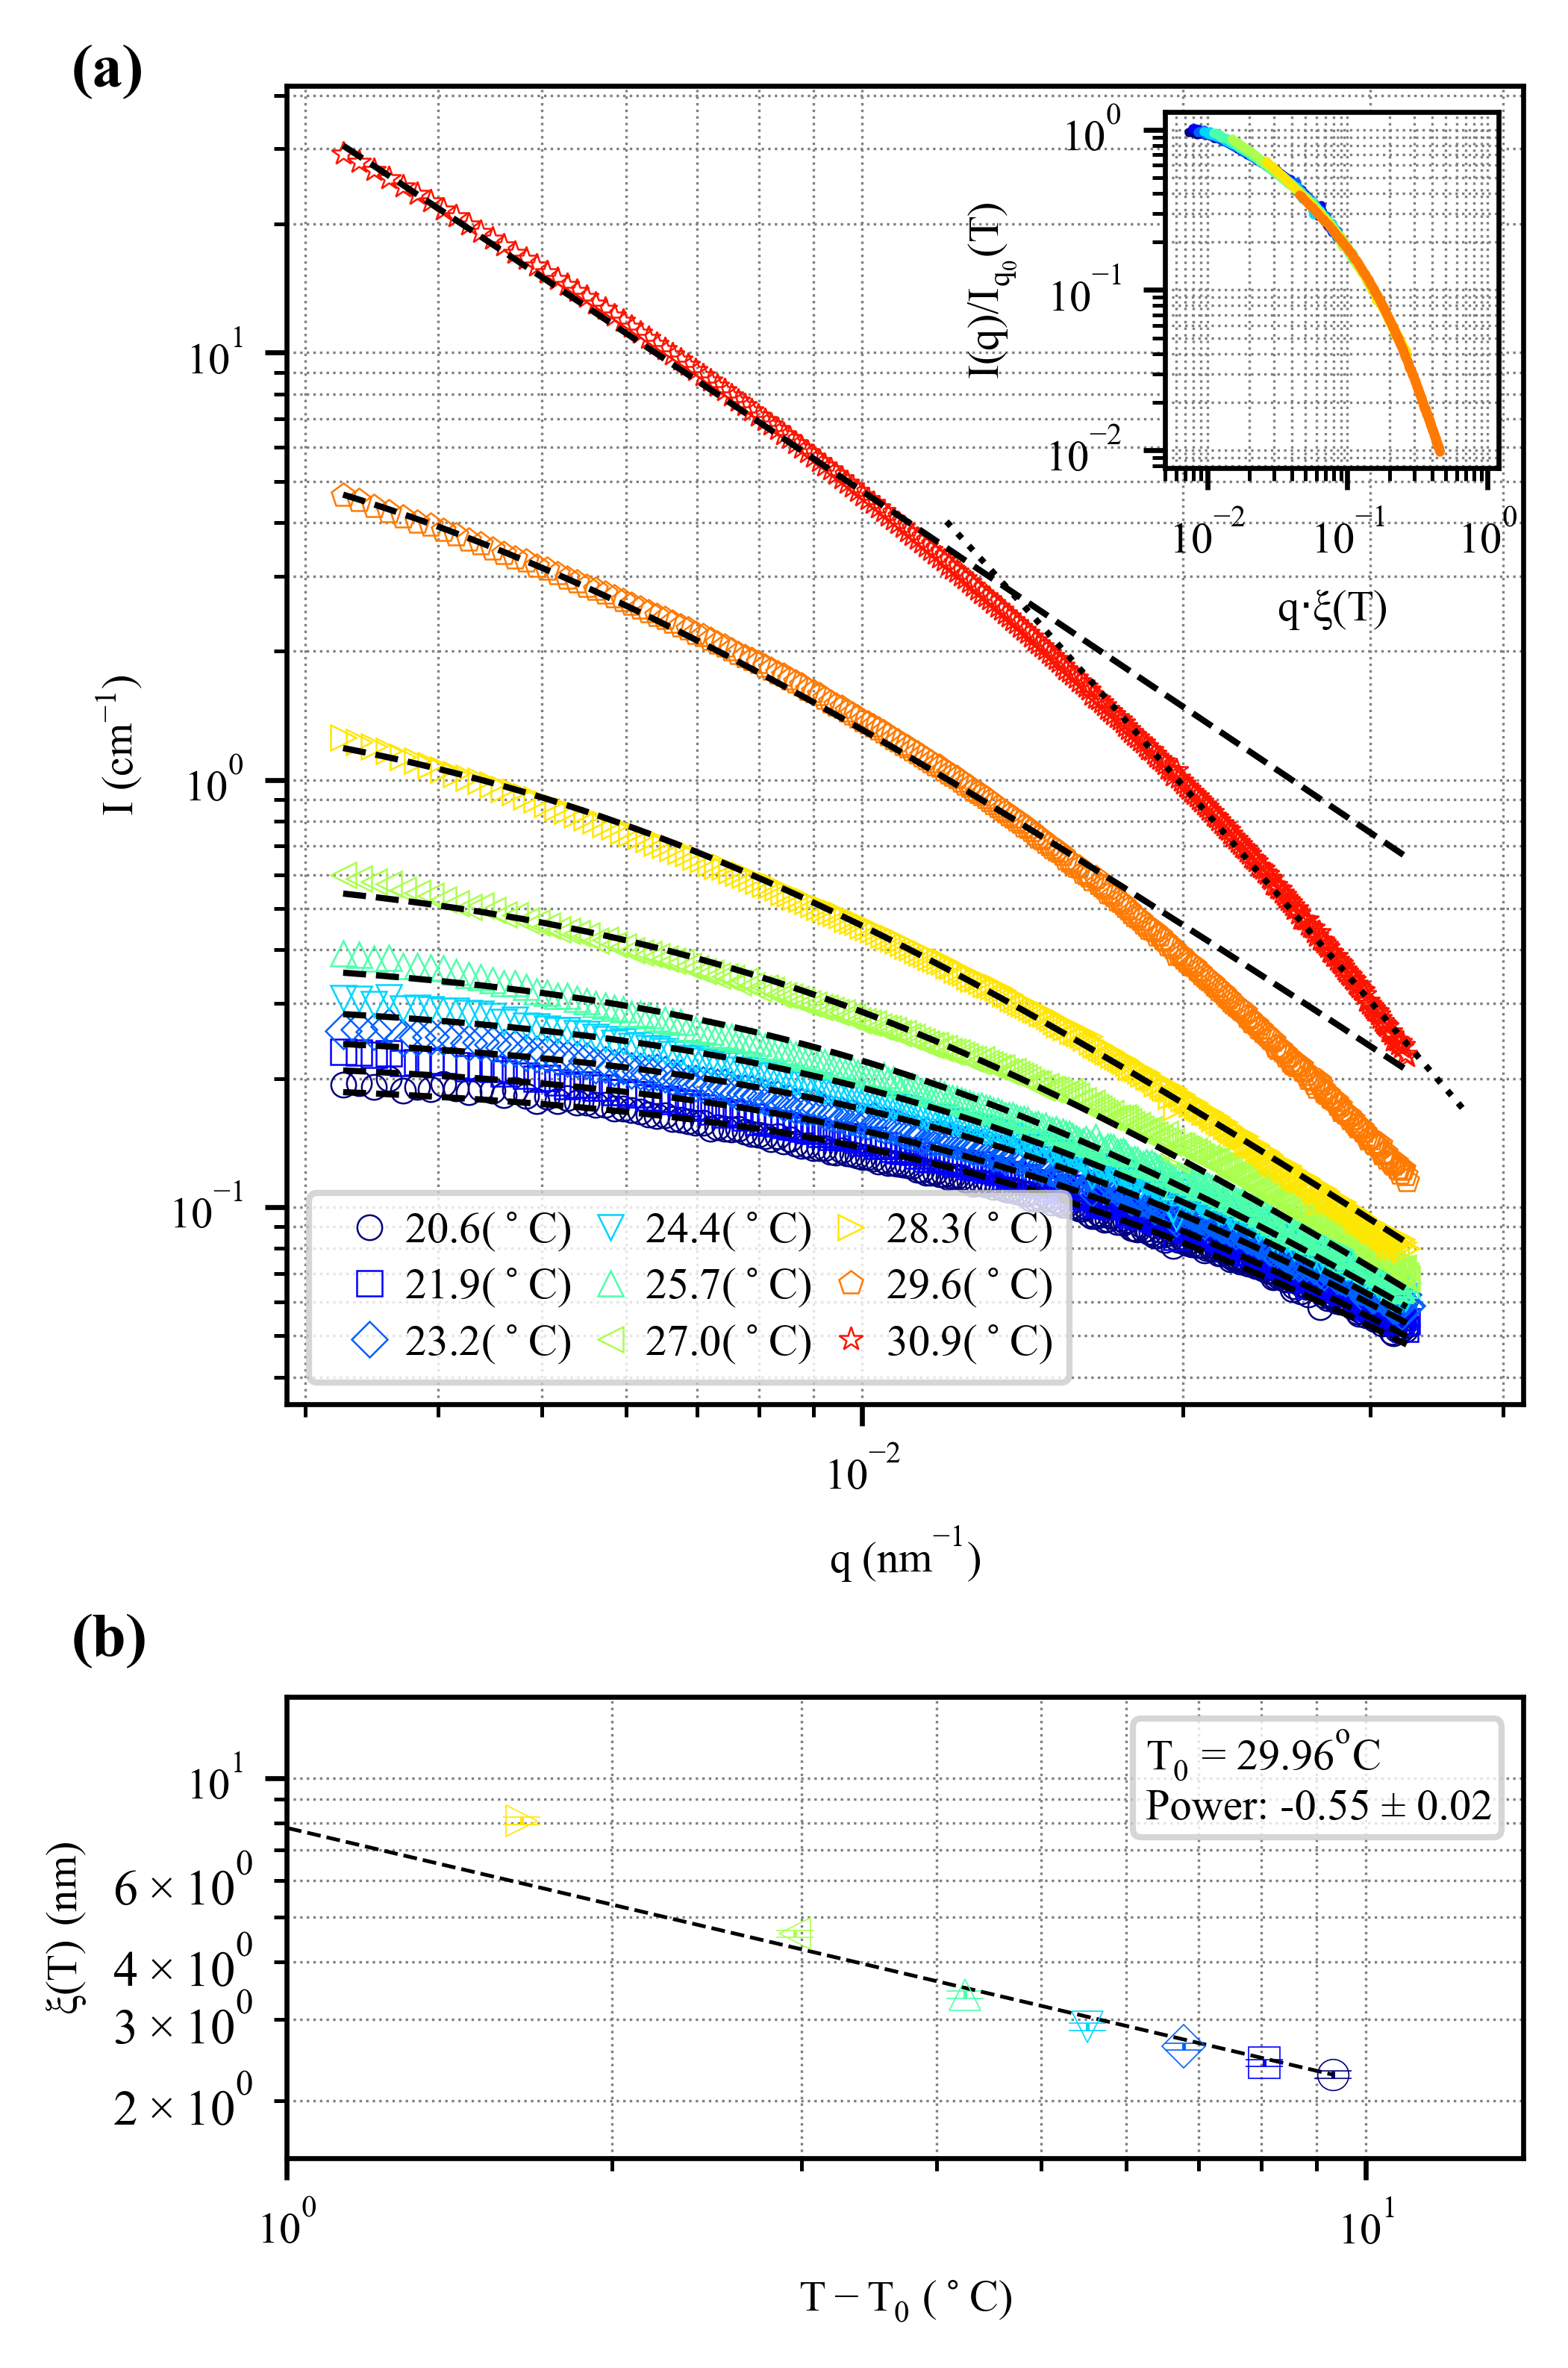

In [11]:
# Add figure labels
fig.text(0.03, 1.01, '(a)', fontsize=10, fontweight='bold', va='top', ha='left')
fig.text(0.03, 0.32, '(b)', fontsize=10, fontweight='bold', va='top', ha='left')

plt.figure(fig)
plt.savefig('SAXS_H06_Fit.pdf', bbox_inches="tight", dpi=600)
plt.show()